# Forecasting power stats
### Maria Silva, June 2022

In this notebook, we use a simple model to forecast raw-byte power and quality-adjusted power. The code for the model can be found in the file `power_model_v2.py`

In particular, we run the model with some dummy data to verify that the model is coded correctly and then we run 4 specific scenarios:

- **Base**: a scenario that uses current network stats (as of the end of May 2022) to set all user-defined model parameters. The idea is to simulate that the network continues to operate as it is doing now. In particular, we assume a constant level of new onboardings, Fil+ rates, and renewals equal to the current level observed. We also give some sensible estimates for the average sector durations.
- **Fil+ all-in**: a scenario almost equal to the base scenario, but where we assume an increase of Fil+ deals to a daily total of 5PiB. This is the goal communicated for Filecoin Plus.
- **Optimistic**: scenario that provides an optimist view of the base scenario. All the user-defined parameters increase when compared with the base scenario, and the Fil+ rate assumes the 5 PiB goal of the Fil+ all-in scenario.
- **Pessimistic**: scenario that provides a pessimistic view of the base scenario. Here, all user-defined parameters decrease. Renewals and onboardings are lower, and sector lengths are the minimum allowed. the Fil+ rate assumes a level of Fil+ onboarding equal to what we are seeing now.


Looking at the results, crossing the baseline does not seem an immediate concern for the network, which gives us time to study and analyze any potential change to the baseline function.

In the base scenario, the network only goes below the baseline after December 2024. Even in the pessimistic scenario, the network only crosses the baseline in September 2023. In other words, the rapid growth Filecoin experienced in 2021 made a nice cushion, which gives us some time to address a baseline crossing  event. 

## 1.  Modelling approach

Assumptions:

* Forecasting is done daily. This means that each forecasting step corresponds to a day and the forecasted power metrics correspond to the value we expect to see at the end of that day.
* We use the current sector states (i.e. known schedule expirations) and we estimate future onboardings and future renewals.
* The daily power onboarded is a constant provided as a tunable parameter. This is a BIG assumption and we will probably want to make the new onboarding a function of time (e.g. have a linear function or a capped liner function). However, for this first deterministic model, having a constant is the easiest approach.
* The sector renewal rate is a constant provided as a tunable parameter.
* Sector duration is a constant provided as a tunable parameter.
* Filecoin Plus sectors have the same renewal rates and sector durations as other sectors. This is something we may want to relax after we do a deeper analysis of renewal rates and sector durations split by sector type.
* Since we currently don't have the known scheduled expirations measured in quality-adjusted power, we approximate it using a provided rate of Fil+ power. This is another assumption we want to remove when we can extract the real data.

Parameters (aka tunable user inputs):

* $\textrm{renewal_rate}$ (%): sector renewal rate (out of scheduled expiration)
* $\textrm{rb_onboard_power}$ (PiB): raw-byte storage amount to be onboarded on a daily basis
* $\textrm{fil_plus_rate}$ (%): percentage of $\textrm{rb_onboard_power}$ that contains Filcoin Plus deals
* $\textrm{duration}$ (days): duration of thd sectors onboarded/renewed
* $\textrm{forecast_lenght}$ (days): number of days in which to run the simulation


Variables extracted from historic data:

* $\textrm{rb_power_zero}$ (PiB): total raw-byte power of the network
* $\textrm{qa_power_zero}$ (PiB): total quality-adjusted power of the network
* $\textrm{rb_known_scheduled_expire_vec}$ (vector of PiB): raw-byte storage power from active sectors scheduled to expire at each day

Additional documentation: [model spec](https://hackmd.io/@msilvaPL/SkapZkrdc)

In [2]:
!pip install altair

  Using cached https://files.pythonhosted.org/packages/0a/fb/56aaac0c69d106e380ff868cd5bb6cccacf2b8917a8527532bc89804a52e/altair-4.2.0-py3-none-any.whl


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import os
import requests
import math
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime
import power_model_v2 as p

warnings.filterwarnings('ignore')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## 2. Global parameters and data

- We will run the forecast for 4 years:

In [4]:
forecast_lenght = 365*4

start_date = datetime.date(2022, 5, 31) 
end_date = start_date + datetime.timedelta(days=forecast_lenght)

- Current network state variables are taken from the observed values on May 30st:

In [5]:
rb_power_zero = 16670
qa_power_zero = 18930

- Scheduled expirations taken from the Starboard API. Note that for this we will exclude terminated sectors!

In [6]:
url = f"https://observable-api-test.starboard.ventures/getdata/sectors_schedule_expiration_full?start={str(start_date)}&end={str(end_date)}"
r = requests.get(url)

# Put data in dataframe
scheduled_df = pd.DataFrame(r.json()["data"])

# Convert bytes to petabytes
pib_convertion = 2**50
scheduled_df["extended_rb"] = scheduled_df["extended_bytes"].astype(float)/pib_convertion
scheduled_df["expired_rb"] = scheduled_df["expired_bytes"].astype(float)/pib_convertion
scheduled_df["open_rb"] = scheduled_df["potential_expire_bytes"].astype(float)/pib_convertion
scheduled_df["extended_qa"] = scheduled_df["extended_bytes_qap"].astype(float)/pib_convertion
scheduled_df["expired_qa"] = scheduled_df["expired_bytes_qap"].astype(float)/pib_convertion
scheduled_df["open_qa"] = scheduled_df["potential_expire_bytes_qap"].astype(float)/pib_convertion

# Total scheduled to expire, excluding terminated
scheduled_df["total_rb"] = scheduled_df["extended_rb"]+scheduled_df["expired_rb"]+scheduled_df["open_rb"]
scheduled_df["total_qa"] = scheduled_df["extended_qa"]+scheduled_df["expired_qa"]+scheduled_df["open_qa"]

# Convert interest date to datetime
scheduled_df["date"] = pd.to_datetime(scheduled_df["interest_date"])

# Filter dates
scheduled_df = scheduled_df[scheduled_df["date"] >= pd.to_datetime(start_date, utc="UTC")]
scheduled_df = scheduled_df[scheduled_df["date"] < pd.to_datetime(end_date, utc="UTC")]

# Get array with the rb_known_scheduled_expire and qa_known_scheduled_expire_vec
rb_known_scheduled_expire_vec = scheduled_df["total_rb"].values
qa_known_scheduled_expire_vec = scheduled_df["total_qa"].values

* Baseline function is defined using the equations from [Filecoin's spec](https://spec.filecoin.io/#section-systems.filecoin_token):

In [7]:
# Baseline function
init_baseline = 2.88888888
baseline_growth = float(math.log(2)/365.0)

baseline_df = pd.DataFrame({
    "index": np.arange(forecast_lenght).astype("float"),
    "date": pd.date_range(start=start_date, freq="d", periods=forecast_lenght),
})
baseline_df["total_power"] =  init_baseline * math.e**(baseline_growth*baseline_df["index"])
baseline_df["power_type"] = "baseline"
baseline_df = baseline_df[["date", "total_power", "power_type"]]

## 3. Run forecast for the base scenario

- User-defined paramaters have values equal to the ones observed at the end of May:
    - renewal_rate: 50%
    - rb_onboard_power: 27 PiB
    - fil_plus_rate: 800 TiB / rb_onboard_power * 1024 = 2.9%
    - duration: 1 year (365 days)

In [8]:
renewal_rate = 0.6
rb_onboard_power = 12.0
fil_plus_rate = 0.211
duration = 360

#### Run model

In [9]:
rb_power_df, qa_power_df = p.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)
qa_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)

df = pd.concat([rb_power_df, qa_power_df]).sort_values(["forecasting_step", "power_type"]).reset_index(drop=True)

#### Plot results

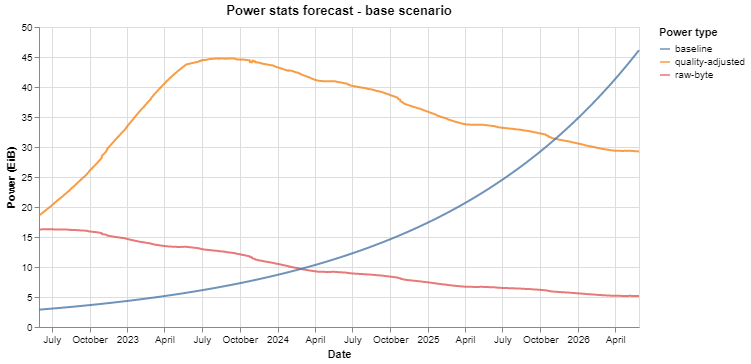

In [10]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast - base scenario"
)

In [11]:
crossing_date = rb_power_df[rb_power_df["total_power"]/1024.0 < baseline_df["total_power"]]["date"].iloc[0].date()

print("Baseline crossing at", str(crossing_date))

Baseline crossing at 2024-02-27


## 4. Run forecast for the FIL+ all-in scenario

- User-defined paramaters assume the goal of 5PiB Fil+ onboarding per day:
    - renewal_rate: 50% (same)
    - rb_onboard_power: 31 PiB (current power plus a 4 PiB increase in Fil+)
    - fil_plus_rate: 5 PiB / rb_onboard_power = 16.1%
    - duration: 1 year (365 days)

In [10]:
renewal_rate = 0.5
rb_onboard_power = 31.0
fil_plus_rate = 0.161
duration = 360

#### Run model

In [11]:
rb_power_df, qa_power_df = p.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)
qa_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)

df = pd.concat([rb_power_df, qa_power_df]).sort_values(["forecasting_step", "power_type"]).reset_index(drop=True)

#### Plot results

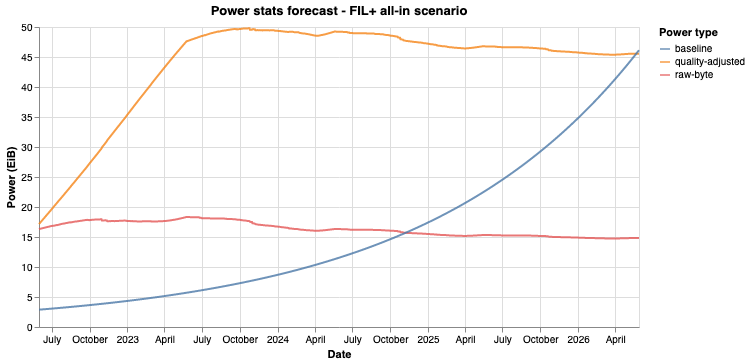

In [12]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast - FIL+ all-in scenario"
)

In [13]:
crossing_date = rb_power_df[rb_power_df["total_power"]/1024.0 < baseline_df["total_power"]]["date"].iloc[0].date()

print("Baseline crossing at", str(crossing_date))

Baseline crossing at 2024-11-08


## 5. Run forecast for the optimistic scenario

- User-defined paramaters have more optimistic values:
    - renewal_rate: 80% (increased renewals)
    - rb_onboard_power: 35 PiB (a 30% increase from current values)
    - fil_plus_rate: 5 PiB / rb_onboard_power = 14.2% (still maintaining the FIL+ goal)
    - onboard_length: 18 months (540 days) -> longer than baseline
    - duration: 18 months (540 days) -> max. allowed for new sectors

In [14]:
renewal_rate = 0.8
rb_onboard_power = 35.0
fil_plus_rate = 0.142
duration = 540

#### Run model

In [15]:
rb_power_df, qa_power_df = p.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)
qa_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)

df = pd.concat([rb_power_df, qa_power_df]).sort_values(["forecasting_step", "power_type"]).reset_index(drop=True)

#### Plot results

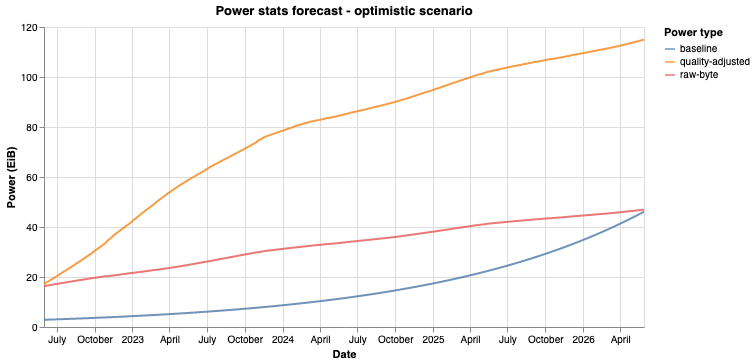

In [16]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast - optimistic scenario"
)

In [17]:
#crossing_date = rb_power_df[rb_power_df["total_power"]/1024.0 < baseline_df["total_power"]]["date"].iloc[0].date()

#print("Baseline crossing at", str(crossing_date))

## 3. Run forecast for the pessimistic scenario

- User-defined paramaters have more pessimistic values:
    - renewal_rate: 30% (lower level of renewals)
    - rb_onboard_power: 24 PiB (10% decrease in onboardings)
    - fil_plus_rate: 800 TiB / rb_onboard_power * 1024 = 3.2% (same value as current)
    - duration: 6 months (180 days) -> minimum allowed

In [18]:
renewal_rate = 0.3
rb_onboard_power = 24.0
fil_plus_rate = 0.032
duration = 180

#### Run model

In [19]:
rb_power_df, qa_power_df = p.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rb_onboard_power,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    renewal_rate,
    fil_plus_rate,
    duration,
    forecast_lenght
)
rb_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)
qa_power_df["date"] = pd.date_range(start=start_date, freq="d", periods=forecast_lenght)

df = pd.concat([rb_power_df, qa_power_df]).sort_values(["forecasting_step", "power_type"]).reset_index(drop=True)

#### Plot results

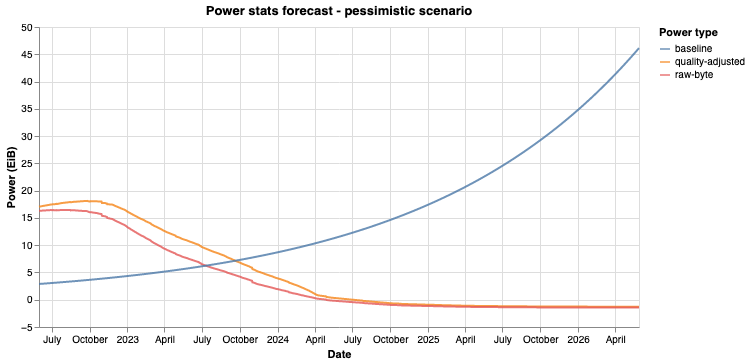

In [20]:
source = df[["date", "total_power", "power_type"]]
source["total_power"] = source["total_power"]/1024.0
source = pd.concat([source, baseline_df])

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('total_power:Q', title="Power (EiB)"),
    color=alt.Color('power_type:N', legend=alt.Legend(title="Power type"))
).properties(
    width=600, height=300, title="Power stats forecast - pessimistic scenario"
)

In [21]:
crossing_date = rb_power_df[rb_power_df["total_power"]/1024.0 < baseline_df["total_power"]]["date"].iloc[0].date()

print("Baseline crossing at", str(crossing_date))

Baseline crossing at 2023-07-11
